In [ ]:
!pip install Bio
!pip install pybedtools

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import pybedtools
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
codes = {'A': [1., 0., 0., 0., 0.],
 'T': [0., 1., 0., 0., 0.],
 'G': [0., 0., 1., 0., 0.],
 'C': [0., 0., 0., 1., 0.],
 'N': [0., 0., 0., 0., 1.],
 }

#DeepZ_may.bed

<Axes: >

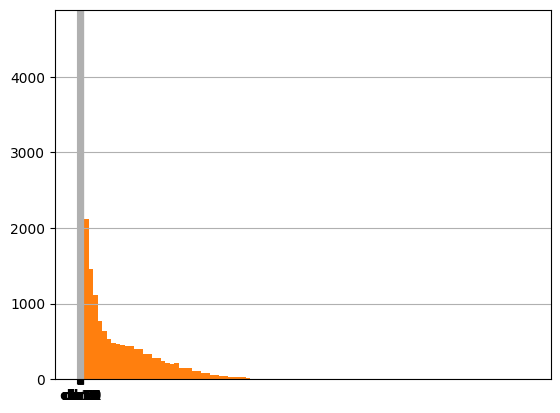

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/DeepZ_may.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)


In [ ]:
pos_df

,chrom,chromStart,chromEnd,len
0,chr1,762616,762898,282
1,chr1,763042,763381,339
2,chr1,763412,763425,13
3,chr1,859216,859231,15
4,chr1,894548,894874,326
...,...,...,...,...
17710,chrM,0,1556,1556
17711,chrM,3388,3731,343
17712,chrM,12845,13206,361
17713,chrM,14607,14643,36


In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,762616,762898,282,230,115,115,762501,763013,512
1,chr1,763042,763381,339,173,86,87,762956,763468,512
2,chr1,763412,763425,13,499,249,250,763163,763675,512
3,chr1,859216,859231,15,497,248,249,858968,859480,512
4,chr1,894548,894874,326,186,93,93,894455,894967,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('DeepZ_may_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('DeepZ_may_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('DeepZ_may_positions.csv')

In [ ]:
pos_df_filter = pd.read_csv('DeepZ_may_positions.csv', index_col=0)
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,762616,762898,282,230,115,115,762501,763013,512
1,chr1,763042,763381,339,173,86,87,762956,763468,512
2,chr1,763412,763425,13,499,249,250,763163,763675,512
3,chr1,859216,859231,15,497,248,249,858968,859480,512
4,chr1,894548,894874,326,186,93,93,894455,894967,512


In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/DeepZ_may_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(17065, 512, 5)

In [ ]:
!mkdir numpy_arrays_data

mkdir: cannot create directory ‘numpy_arrays_data’: File exists


In [ ]:
np.save('/content/numpy_arrays_data/DeepZ_may_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/DeepZ_may_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/DeepZ_may_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#Kouzine.bed

<Axes: >

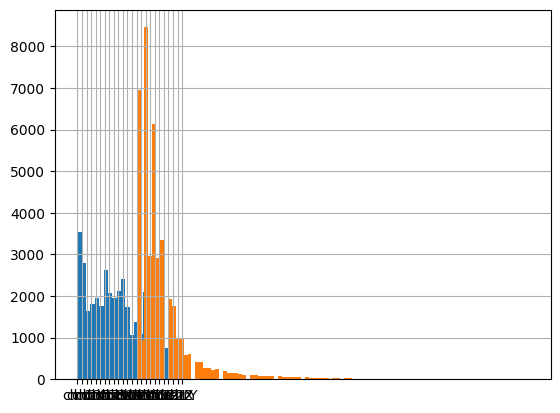

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/Kouzine.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,845543,845560,17,495,247,248,845296,845808,512
1,chr1,845627,845642,15,497,248,249,845379,845891,512
2,chr1,846050,846065,15,497,248,249,845802,846314,512
3,chr1,846142,846161,19,493,246,247,845896,846408,512
4,chr1,848436,848452,16,496,248,248,848188,848700,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('Kouzine_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('Kouzine_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('Kouzine_positions.csv')

In [ ]:
pos_df_filter = pd.read_csv('Kouzine_positions.csv', index_col=0)
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,845543,845560,17,495,247,248,845296,845808,512
1,chr1,845627,845642,15,497,248,249,845379,845891,512
2,chr1,846050,846065,15,497,248,249,845802,846314,512
3,chr1,846142,846161,19,493,246,247,845896,846408,512
4,chr1,848436,848452,16,496,248,248,848188,848700,512


In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/Kouzine_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(42654, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/Kouzine_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/Kouzine_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/Kouzine_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#Wu.bed

<Axes: >

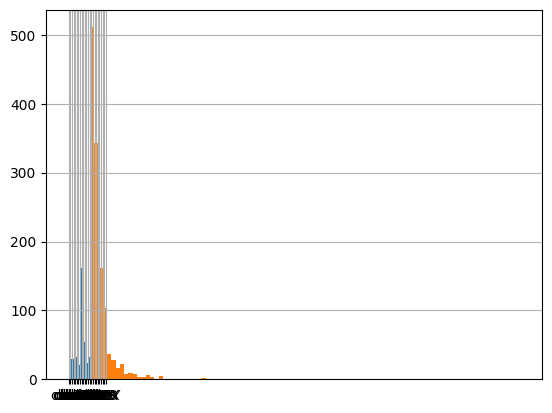

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/Wu.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,1262410,1262423,13,499,249,250,1262161,1262673,512
1,chr1,2276448,2276466,18,494,247,247,2276201,2276713,512
2,chr1,2276516,2276536,20,492,246,246,2276270,2276782,512
3,chr1,2277268,2277295,27,485,242,243,2277026,2277538,512
4,chr1,2278787,2278800,13,499,249,250,2278538,2279050,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('Wu_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('Wu_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('Wu_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/Wu_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(1283, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/Wu_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/Wu_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/Wu_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#WuKou.bed

<Axes: >

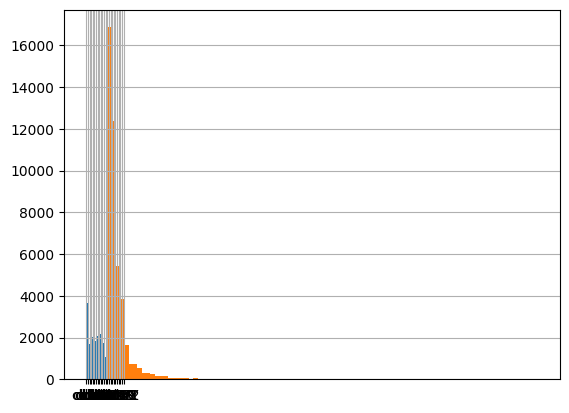

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,845543,845560,17,495,247,248,845296,845808,512
1,chr1,845627,845642,15,497,248,249,845379,845891,512
2,chr1,846050,846065,15,497,248,249,845802,846314,512
3,chr1,846142,846161,19,493,246,247,845896,846408,512
4,chr1,848436,848452,16,496,248,248,848188,848700,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('WuKou_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('WuKou_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('WuKou_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(43937, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/WuKou_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/WuKou_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#WuKou16

<Axes: >

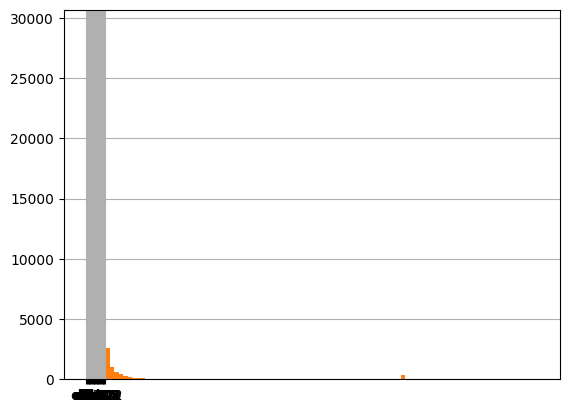

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou16.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,845543,845560,17,495,247,248,845296,845808,512
1,chr1,845627,845642,15,497,248,249,845379,845891,512
2,chr1,846050,846065,15,497,248,249,845802,846314,512
3,chr1,846142,846161,19,493,246,247,845896,846408,512
4,chr1,848436,848452,16,496,248,248,848188,848700,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('WuKou2016_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('WuKou2016_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('WuKou2016_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(44299, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/WuKou2016_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/WuKou2016_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/WuKou2016_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#zdna2009.bed

<Axes: >

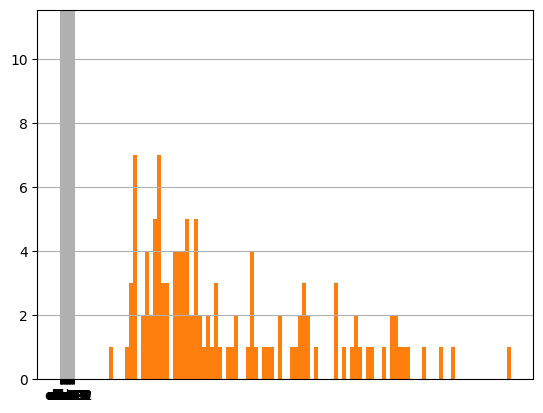

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2009.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,50727082,50727286,204,308,154,154,50726928,50727440,512
1,chr1,86214297,86214672,375,137,68,69,86214229,86214741,512
2,chr1,91283592,91284068,476,36,18,18,91283574,91284086,512
3,chr1,154574489,154574721,232,280,140,140,154574349,154574861,512
4,chr1,199808010,199808229,219,293,146,147,199807864,199808376,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('zdna2009_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('zdna2009_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('zdna2009_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2009_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(107, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/zdna2009_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2009_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/zdna2009_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#zdna2016.bed

<Axes: >

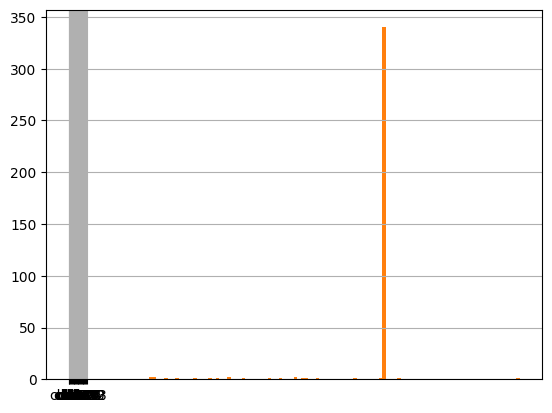

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2016.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr17,19411362,19411746,384,128,64,64,19411298,19411810,512
1,chr1,58747826,58748210,384,128,64,64,58747762,58748274,512
2,chr17,80055180,80055564,384,128,64,64,80055116,80055628,512
3,chr8,124408480,124408864,384,128,64,64,124408416,124408928,512
4,chr5,57755709,57756093,384,128,64,64,57755645,57756157,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('zdna2016_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('zdna2016_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('zdna2016_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(362, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/zdna2016_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/zdna2016_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/zdna2016_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#ZHUNT.bed

<Axes: >

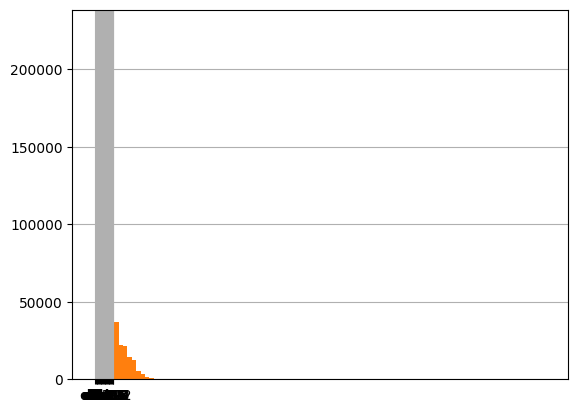

In [ ]:
pos_df = pd.read_csv('/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/ZHUNT.bed',
 sep='\t', comment='t', header=None)
header = ['chrom', 'chromStart', 'chromEnd']
pos_df.columns = header[:len(pos_df.columns)]
pos_df['len'] = pos_df.chromEnd - pos_df.chromStart
pos_df.head()
plt.hist(pos_df.chrom, bins=len(pos_df.chrom.unique()))
pos_df.len.quantile(0.5)
pos_df.len[pos_df.len > 512].count()
pos_df.len[pos_df.len <= 512].count() / pos_df.len.count()
pos_df.len.hist(bins=100)

In [ ]:
quad_len = 512
pos_df_filter = pos_df[pos_df.len
 <= quad_len].copy().reset_index(drop=True)
pos_df_filter.len.max()
pos_df_filter['add_len'] = quad_len - pos_df_filter.len
pos_df_filter['left_add_len'] = (pos_df_filter.add_len
 / 2).astype('int64')
pos_df_filter['right_add_len'] = pos_df_filter.add_len \
 - pos_df_filter.left_add_len
pos_df_filter['new_chromStart'] = pos_df_filter.chromStart.astype('int64') \
 - pos_df_filter.left_add_len.astype('int64')
pos_df_filter['new_chromEnd'] = pos_df_filter.chromEnd.astype('int64') \
 + pos_df_filter.right_add_len.astype('int64')
pos_df_filter['new_len'] = pos_df_filter.new_chromEnd.astype('int64') \
 - pos_df_filter.new_chromStart.astype('int64')
pos_df_filter.head()

,chrom,chromStart,chromEnd,len,add_len,left_add_len,right_add_len,new_chromStart,new_chromEnd,new_len
0,chr1,750333,750348,15,497,248,249,750085,750597,512
1,chr1,759607,759625,18,494,247,247,759360,759872,512
2,chr1,762927,762944,17,495,247,248,762680,763192,512
3,chr1,763029,763047,18,494,247,247,762782,763294,512
4,chr1,763073,763090,17,495,247,248,762826,763338,512


In [ ]:
pos_df_filter[['chrom', 'new_chromStart', 'new_chromEnd'
 ]].to_csv('ZHUNT_filter_norm_to_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter[['chrom', 'chromStart', 'chromEnd'
 ]].to_csv('ZHUNT_filter_512.bed', sep='\t',
 header=None, index=None)
pos_df_filter.to_csv('ZHUNT_positions.csv')

In [ ]:
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/ZHUNT_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      one_hot = []
      for s in line.upper():
        if s != '\n':
          one_hot.append(codes[s])
      one_hot_quads.append(one_hot)
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape

(409006, 512, 5)

In [ ]:
np.save('/content/numpy_arrays_data/ZHUNT_filter-norm_to_512.npy', one_hot_quads_np)

In [ ]:
# Normalisation + labeling
one_hot_quads = []
line_num = 0
with open('/content/drive/My Drive/data_for_gans/preprocessed_fastas/ZHUNT_filter-norm_to_512.fasta', 'r') as f:
  for line in f:
    if line[0] != '>' and len(line) == quad_len + 1:
      left = pos_df_filter.iloc[line_num].left_add_len
      right = left + pos_df_filter.iloc[line_num].len
      one_hot = []
      for (i, s) in enumerate(line.upper()):
        pos = 0.
        if left <= i and i < right:
          pos = 1.
        if s != '\n':
          one_hot.append(codes[s] + [pos])
      one_hot_quads.append(np.array(one_hot))
      line_num += 1
one_hot_quads_np = np.array(one_hot_quads)
one_hot_quads_np.shape
np.save('/content/numpy_arrays_data/ZHUNT_filter-norm_to_512_labeled.npy',
 one_hot_quads_np)

#Class

In [ ]:
files_to_process = [
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/DeepZ_may.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/Kouzine.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/Wu.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/WuKou16.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2009.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/zdna2016.bed',
    '/content/drive/My Drive/data_for_gans/data/hg19_zdna/raw/ZHUNT.bed',
    ]

# Load

In [ ]:
file_1 = np.load('/content/numpy_arrays_data/DeepZ_may_filter-norm_to_512.npy')
file_2 = np.load('/content/numpy_arrays_data/Kouzine_filter-norm_to_512.npy')
file_3 = np.load('/content/numpy_arrays_data/Wu_filter-norm_to_512.npy')
file_4 = np.load('/content/numpy_arrays_data/WuKou_filter-norm_to_512.npy')
file_5 = np.load('/content/numpy_arrays_data/WuKou2016_filter-norm_to_512.npy')
file_6 = np.load('/content/numpy_arrays_data/zdna2009_filter-norm_to_512.npy')
file_7 = np.load('/content/numpy_arrays_data/zdna2016_filter-norm_to_512.npy')
file_8 = np.load('/content/numpy_arrays_data/ZHUNT_filter-norm_to_512.npy')

In [ ]:
np.save('/content/drive/My Drive/np_zdna/DeepZ_may_filter-norm_to_512.npy', file_1)
np.save('/content/drive/My Drive/np_zdna/Kouzine_filter-norm_to_512.npy', file_2)
np.save('/content/drive/My Drive/np_zdna/Wu_filter-norm_to_512.npy', file_3)
np.save('/content/drive/My Drive/np_zdna/WuKou_filter-norm_to_512.npy', file_4)
np.save('/content/drive/My Drive/np_zdna/WuKou2016_filter-norm_to_512.npy', file_5)
np.save('/content/drive/My Drive/np_zdna/zdna2009_filter-norm_to_512.npy', file_6)
np.save('/content/drive/My Drive/np_zdna/zdna2016_filter-norm_to_512.npy', file_7)

In [ ]:
np.save('/content/drive/My Drive/np_zdna/ZHUNT_filter-norm_to_512.npy', file_8)

In [ ]:
print(file_1.shape)
print(file_2.shape)
print(file_3.shape)
print(file_4.shape)
print(file_5.shape)
print(file_6.shape)
print(file_7.shape)
print(file_8.shape)

(17065, 512, 5)
(42654, 512, 5)
(1283, 512, 5)
(43937, 512, 5)
(44299, 512, 5)
(107, 512, 5)
(362, 512, 5)
(409006, 512, 5)


In [ ]:
np.concatenate((file_6, file_7), axis=0).shape

(469, 512, 5)

In [ ]:
file_1_labeled = np.save('/content/numpy_arrays_data/DeepZ_may_filter-norm_to_512_labeled.npy')
file_2_labeled = np.save('/content/numpy_arrays_data/Kouzine_filter-norm_to_512_labeled.npy')
file_3_labeled = np.save('/content/numpy_arrays_data/Wu_filter-norm_to_512_labeled.npy')
file_4_labeled = np.save('/content/numpy_arrays_data/WuKou_filter-norm_to_512_labeled.npy')
file_5_labeled = np.save('/content/numpy_arrays_data/WuKou2016_filter-norm_to_512_labeled.npy')
file_6_labeled = np.save('/content/numpy_arrays_data/zdna2009_filter-norm_to_512_labeled.npy')
file_7_labeled = np.save('/content/numpy_arrays_data/zdna2016_filter-norm_to_512_labeled.npy')
file_8_labeled = np.save('/content/numpy_arrays_data/ZHUNT_filter-norm_to_512_labeled.npy')